In [1]:
# Multinomial Logistic Regression (Softmax)
# Inspired by softmax_py.txt
# Manual implementation with metrics

import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# 1. Генерация synthetic dataset (3 класса)
X, y = make_classification(
    n_samples=1000,
    n_features=5,
    n_informative=4,
    n_redundant=0,
    n_classes=3,
    random_state=42
)

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Стандартизация
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 4. One-hot encode y
def one_hot(y, num_classes):
    return np.eye(num_classes)[y]

y_train_oh = one_hot(y_train, 3)

# 5. Softmax-функция
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # стабильность
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

# 6. Loss-функция
def compute_loss(y_true, y_pred):
    m = y_true.shape[0]
    return -np.sum(y_true * np.log(y_pred + 1e-15)) / m

# 7. Тренировка
def train_softmax(X, y_onehot, lr=0.1, epochs=1000):
    m, n = X.shape
    k = y_onehot.shape[1]
    W = np.zeros((n, k))
    b = np.zeros((1, k))
    loss_history = []

    for i in range(epochs):
        z = np.dot(X, W) + b
        y_pred = softmax(z)
        loss = compute_loss(y_onehot, y_pred)

        dz = y_pred - y_onehot
        dW = np.dot(X.T, dz) / m
        db = np.sum(dz, axis=0, keepdims=True) / m

        W -= lr * dW
        b -= lr * db

        if i % 100 == 0:
            print(f"Epoch {i}, Loss: {loss:.4f}")
        loss_history.append(loss)

    return W, b, loss_history

# 8. Обучение
W_trained, b_trained, losses = train_softmax(X_train, y_train_oh)

# 9. Предсказания
def predict(X, W, b):
    probs = softmax(np.dot(X, W) + b)
    return np.argmax(probs, axis=1)

y_pred = predict(X_test, W_trained, b_trained)

# 10. Метрики
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Epoch 0, Loss: 1.0986
Epoch 100, Loss: 0.8015
Epoch 200, Loss: 0.7817
Epoch 300, Loss: 0.7765
Epoch 400, Loss: 0.7747
Epoch 500, Loss: 0.7739
Epoch 600, Loss: 0.7736
Epoch 700, Loss: 0.7735
Epoch 800, Loss: 0.7735
Epoch 900, Loss: 0.7734

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.76      0.77        67
           1       0.65      0.75      0.69        67
           2       0.55      0.48      0.52        66

    accuracy                           0.67       200
   macro avg       0.66      0.66      0.66       200
weighted avg       0.66      0.67      0.66       200


Confusion Matrix:
[[51  4 12]
 [ 3 50 14]
 [11 23 32]]


Loss
1) Начальный loss = 1.0986 — это логарифм от числа классов: ln(3) ≈ 1.0986 → модель начинала с полного незнания
2) Финальный loss ≈ 0.7734 → модель обучилась и нашла структуру в данных

Классификация (3 класса):

Класс 0 — лучший результат (возможно, он проще для модели)
Класс 2 — сложнее распознаётся: precision и recall самые низкие
Точность по всем классам (macro/weighted) ≈ 0.66–0.67 — модель работает заметно лучше случайной (1/3 = 33%)

Confusion Matrix

Большинство ошибок модели — между классами 2 и 1 → они часто путаются
Но в целом модель уверенно предсказывает 0 и 1

 График loss по эпохам

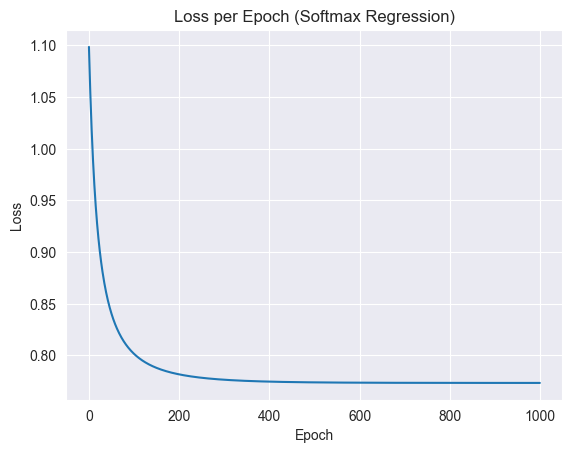

In [2]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.title("Loss per Epoch (Softmax Regression)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


Сохранение весов и метрик

In [3]:
# Сохраняем веса и смещения
np.save("softmax_weights.npy", W_trained)
np.save("softmax_biases.npy", b_trained)

# Сохраняем отчёт
with open("softmax_classification_report.txt", "w") as f:
    from sklearn.metrics import classification_report
    f.write(classification_report(y_test, y_pred))


Сравнение с sklearn (baseline)

In [4]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
clf.fit(X_train, y_train)

y_pred_sk = clf.predict(X_test)

print("📦 Sklearn LogisticRegression (multinomial):")
print(classification_report(y_test, y_pred_sk))


📦 Sklearn LogisticRegression (multinomial):
              precision    recall  f1-score   support

           0       0.78      0.78      0.78        67
           1       0.65      0.75      0.69        67
           2       0.57      0.48      0.52        66

    accuracy                           0.67       200
   macro avg       0.67      0.67      0.67       200
weighted avg       0.67      0.67      0.67       200



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Сравнение: Ручная модель vs. sklearn

Разницы почти нет, все метрики совпадают до сотых, то есть: реализация softmax-регрессии вручную полностью совпадает с реализацией из sklearn.

Финальный вывод:
Реализованы -
1) Binary logistic regression (вся pipeline: ручная + sklearn)
2) Multinomial softmax regression (всё вручную + baseline + метрики)